# 📜Summary
**Introduction:** Efficient operations in the airline industry hinge on maximizing the number of flights to optimize revenue. However, maintaining a tight schedule poses a significant risk of network delays. A single delayed flight not only impacts its immediate successor but can ripple through subsequent flights, amplifying disruptions across the network. This is why Airlines does it best to improve their On-Time Performance.

**Problem:** How can we maximize the number of flights while mitigating the risk of disruption?

**Hypothesis:** If we are able to know the chances of a flight being delayed, we  can plan our flight schedules better.

**Goal:** Predict the probability of delays for flights.

[kaggle](https://www.kaggle.com/code/fiftythirtyfour/usa-airline-on-time-performance/edit)

# 🌳Editor's Notes
## 🌿Iterate Fast
Always favor to do iteration fast. Work on a sample. Process the data and save it if you only need to do it once.

## 🌿Always use "g" when exploring Data.
Explore data using variable g and make sure you don't go out of the cell. Don't leave random variables lying around.


✅Converted all date time to utc time  
✅Replaced airport placeholder codes to correct iata codes  
✅Calculated Scheduled and Actual Block times  
📌elapsed time and all other times are not minutes duration. It means something else.  

# 🤓Data Science

In [1]:
! pip install timezonefinder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import pytz
from timezonefinder import TimezoneFinder

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 200
pd.options.display.max_rows = 400

In [3]:
## Load
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv')
airl = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')

In [4]:
## Get Timezones
def getTimezone(latlon):
    lat, lon = latlon
    tf = TimezoneFinder()
    return tf.timezone_at(lat=lat, lng=lon)

def processAirports(path):
    a = pd.read_csv(path)
    a.columns = a.columns.str.lower()

    a.loc[a['iata_code'] == "UST", ["latitude", "longitude"]] = (29.9581, -81.3416)
    a.loc[a['iata_code'] == "ECP", ["latitude", "longitude"]] = (30.3583, -85.7956)
    a.loc[a['iata_code'] == "PBG", ["latitude", "longitude"]] = (44.6509, -73.4663)

    a['timezone'] = a[['latitude', 'longitude']].apply(getTimezone, axis=1)
    a.to_csv('airports.csv')

## processAirports('/kaggle/input/flight-delays/airports.csv', index=False) ## Process this once, then save.
airp = pd.read_csv('/kaggle/input/airport-timezone/airports_timezone.csv')
timezone = dict(zip(airp['iata_code'], airp['timezone'].apply(lambda x: pytz.timezone(x)) ))

In [5]:
## getting placeholder to iata
def getFreqAirport(a):
    plc = [x for x in a.unique() if len(x) > 3]
    chk = pd.Series([x for x in a if len(x) == 3])
    return (plc[0] if plc else None, chk.mode().iloc[0] if not chk.mode().empty else None)

def getIata(b):
    b = b.groupby(['airline', 'flight_number', 'scheduled_departure'])['origin_airport'].apply(getFreqAirport).apply(pd.Series)
    b = b.reset_index().dropna()
    b.columns = ['airline', 'flight_number', 'scheduled_departure', 'placeholder', 'iata']
    b = b.groupby(['placeholder']).apply(lambda x: x['iata'].mode().iloc[0]).reset_index()
    b.columns = ['placeholder', 'iata']
    return dict(zip(b['placeholder'], b['iata']))

In [6]:
def convert_int_to_time(integer_time):
    if integer_time == 2400:
        hours = 0
        minutes = 0
    else:
        hours = integer_time // 100
        minutes = integer_time % 100

    return dt.time(hours, minutes)

In [7]:
def localize_and_convert_to_utc(stamp, timezone):
    if pd.isna(stamp):
        return pd.NaT
    try:
        localized_time = pd.Timestamp(stamp).tz_localize(timezone, ambiguous=True, nonexistent='shift_forward')
        if pd.isna(localized_time):
            print('invalid datetime: ', stamp, localized_time, timezone, pd.isna(stamp))
            return pd.NaT  # Return NaT if localization failed (e.g., NaTType)
        utc_time = localized_time.astimezone(pytz.utc).replace(tzinfo=None)
        return utc_time
    except Exception as e:
        print(f"Error localizing time: {e}", stamp, localized_time, timezone, pd.isna(stamp))
        return pd.NaT

In [8]:
## Cleaning
def cleanData(a):
    a.columns = a.columns.str.lower()
    a['origin_airport'] = a['origin_airport'].astype(str)
    a['destination_airport'] = a['destination_airport'].astype(str)
    a['scheduled_departure'] = [convert_int_to_time(x) for x in a['scheduled_departure']]
    a['scheduled_arrival'] = [convert_int_to_time(x) for x in a['scheduled_arrival']]
    a['departure_time'] = [convert_int_to_time(x) for x in a['departure_time'].fillna(0).astype(int)]
    a['arrival_time'] = [convert_int_to_time(x) for x in a['arrival_time'].fillna(0).astype(int)]
    
    a['std_ls_date'] = pd.to_datetime(a[['year', 'month', 'day']])

    a['std_ls_date_time'] = pd.to_datetime(a['std_ls_date'].astype(str) + ' ' + a['scheduled_departure'].astype(str))
    a['sta_ls_date_time'] = pd.to_datetime(a['std_ls_date'].astype(str) + ' ' + a['scheduled_arrival'].astype(str))
    ## if departure is greater than arrival, add 1 day to arrival.
    a.loc[a['std_ls_date_time'] > a['sta_ls_date_time'], 'sta_ls_date_time'] += pd.Timedelta(days=1)
    
    a['atd_ls_date_time'] = pd.to_datetime(a['std_ls_date_time'].dt.date.astype(str) + ' ' + a['departure_time'].astype(str))
    a['ata_ls_date_time'] = pd.to_datetime(a['sta_ls_date_time'].dt.date.astype(str) + ' ' + a['arrival_time'].astype(str))
        
    a['anchor'] = a['airline'] + [str(x).zfill(5) for x in a['flight_number']] + '|' + a['std_ls_date'].dt.strftime('%Y-%m-%d') + '|' + df['origin_airport'].astype(str)
    a['otp_dly15'] = np.where(a['departure_delay'] > 15, 0.0, 1.0)
    return a

def mapData(a, tz, ia):
    ### Replace placeholder for October with actual airport iata codes.
    a['origin_airport'] = a['origin_airport'].replace(ia)
    a['destination_airport'] = a['destination_airport'].replace(ia)
    a['orig_timezone'] = a['origin_airport'].map(tz)    
    a['dest_timezone'] = a['destination_airport'].map(tz)    
    return a

def convertUTC(a):
    ### convert to local to utc
    a['std_z_date_time'] = a.apply(lambda row: localize_and_convert_to_utc(row['std_ls_date_time'], row['orig_timezone']), axis=1)
    a['sta_z_date_time'] = a.apply(lambda row: localize_and_convert_to_utc(row['sta_ls_date_time'], row['dest_timezone']), axis=1)
    a['schedule_block'] = a['sta_z_date_time'] - a['std_z_date_time']
    
    a['atd_z_date_time'] = a.apply(lambda row: localize_and_convert_to_utc(row['atd_ls_date_time'], row['orig_timezone']), axis=1)
    a['ata_z_date_time'] = a.apply(lambda row: localize_and_convert_to_utc(row['ata_ls_date_time'], row['dest_timezone']), axis=1)
    a['actual_block'] = a['ata_z_date_time'] - a['atd_z_date_time']
    return a

In [9]:
df = cleanData(df)

iatacodes = getIata(df)
## Manually added. These flights are new for October.
iatacodes['10577'] = 'BGM'
iatacodes['10666'] = 'BLI'

df = mapData(df, timezone, iatacodes)
df = convertUTC(df)

In [10]:
## Organize
dly = [x for x in df.columns if 'delay' in x]
num = [x for x in df.columns if df.dtypes[x] in ('float', 'int64')]
cat = [x for x in df.columns if df.dtypes[x] == "object"]
target = 'departure_delay'
num.remove(target)

## Split
train = df.query('airline not in ("AA", "US", "OO")')
test = df.query('airline == "OO"')

# 🤓Data Science

In [11]:
### Timezone bit. Get UTC
### 💪 Always iterate fast.
g = df
g = g.loc[g['ata_ls_date_time'].notnull() & g['ata_z_date_time'].isnull()]
# g = g.query('origin_airport == "JFK" and destination_airport == "LAX"')
# g['departure_time'] = [convert_int_to_time(x) for x in g['departure_time'].fillna(0).astype(int)]
# g['arrival_time'] = [convert_int_to_time(x) for x in g['arrival_time'].fillna(0).astype(int)]

# g['atd_ls_date_time'] = pd.to_datetime(g['std_ls_date_time'].dt.date.astype(str) + ' ' + g['departure_time'].astype(str))
# g['ata_ls_date_time'] = pd.to_datetime(g['sta_ls_date_time'].dt.date.astype(str) + ' ' + g['arrival_time'].astype(str))
# g['atd_z_date_time'] = g.apply(lambda row: localize_and_convert_to_utc(row['atd_ls_date_time'], row['orig_timezone']), axis=1)
# g['ata_z_date_time'] = g.apply(lambda row: localize_and_convert_to_utc(row['ata_ls_date_time'], row['dest_timezone']), axis=1)
# g['timediff'] = g['ata_z_date_time'] - g['atd_z_date_time']

g = convertUTC(g)
g = g[[
    'anchor'
#     , 'orig_timezone'
#     , 'dest_timezone'
#     , 'std_ls_date_time', 'std_z_date_time'
    , 'sta_ls_date_time', 'sta_z_date_time'
#     , 'atd_ls_date_time', 'atd_z_date_time'
    , 'ata_ls_date_time', 'ata_z_date_time'
    , 'scheduled_arrival', 'arrival_time'
    , 'arrival_delay', 'diverted'
]]
g

,anchor,sta_ls_date_time,sta_z_date_time,ata_ls_date_time,ata_z_date_time,scheduled_arrival,arrival_time,arrival_delay,diverted


In [12]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

departure_delay        1.000000
arrival_delay          0.944818
airline_delay          0.587769
late_aircraft_delay    0.559684
weather_delay          0.251968
wheels_off             0.171962
air_system_delay       0.128953
taxi_out               0.065530
wheels_on              0.057823
cancelled              0.035646
elapsed_time           0.033674
scheduled_time         0.029432
distance               0.025458
diverted               0.025350
air_time               0.025053
taxi_in                0.023484
security_delay         0.011277
day                   -0.000214
flight_number         -0.006996
day_of_week           -0.014607
month                 -0.024249
otp_dly15             -0.659777
year                        NaN
Name: departure_delay, dtype: float64

# > Merger of American and US Airways
There was a Merger of American Airlines and US Airways in June 2015. Southwest, Delta and American Airlines have the biggest volume of flights in 2015.

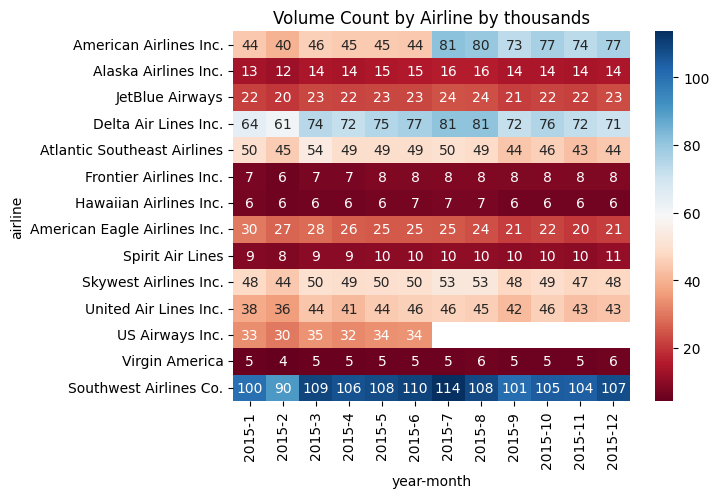

In [13]:
g = df.pivot_table('flight_number', index='airline'
              , columns=[df['year'], df['month']]
              , aggfunc='count') / 1000
g.index = g.index.map(airl.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, cmap='RdBu', annot=True, fmt='.0f')

plt.title("Volume Count by Airline by thousands");

# > Airline Departure On-Time Performance.
Lower volume flights like Hawaiian, Virgin and Alaska Airlines are almost always on time. Delta and American airlines are also on time taking into consideration that they have more flights in 2015.

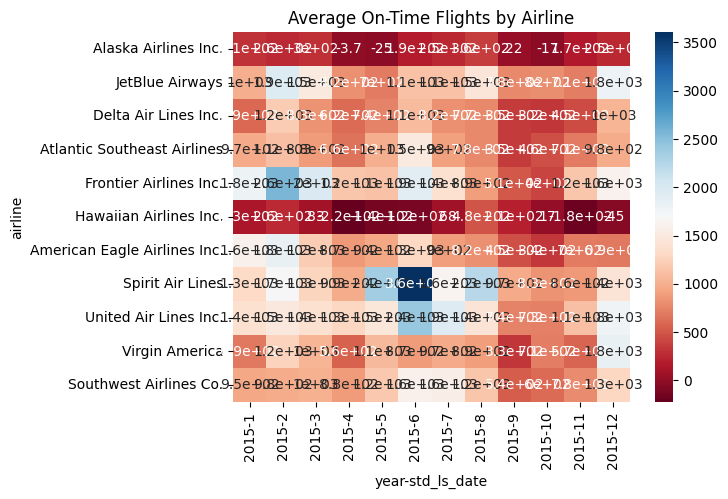

In [14]:
g = train.query('cancelled == 0 and diverted == 0')
g = g.pivot_table(target, index='airline'
             , columns=[g['year'], g['std_ls_date'].dt.month]
             , aggfunc='mean')  * 100
g.index = g.index.map(airl.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, annot=True, cmap='RdBu')
plt.title('Average On-Time Flights by Airline');

# > Flight Plan

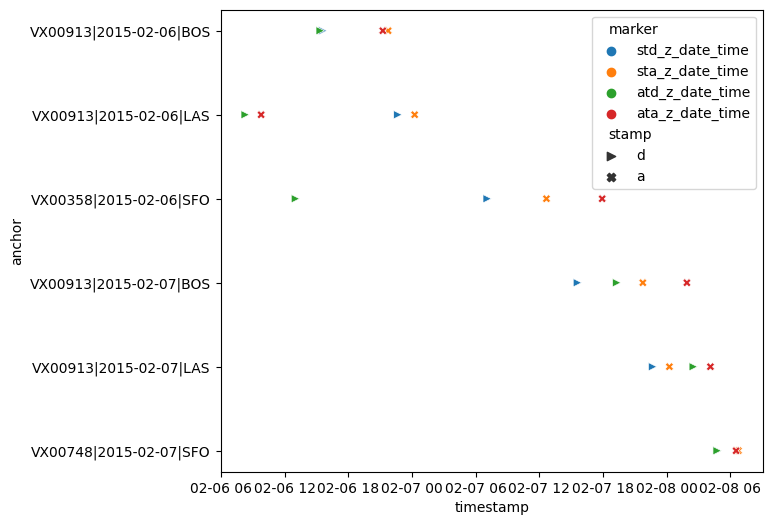

In [15]:
vx = train.query('airline=="VX"')
g = vx.query('tail_number == "N361VA"')
g = g.query('"2015-02-06" <= std_ls_date <= "2015-02-07"')
g = g.loc[~g['departure_delay'].isnull()]
g = g[[
    'anchor'
    ,'std_z_date_time'
   , 'sta_z_date_time'    
   , 'atd_z_date_time'
   , 'ata_z_date_time'
      ]]

g = pd.melt(g, id_vars='anchor', var_name='marker', value_name='timestamp')
g['stamp'] = g['marker'].str[2:3]
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot (g, x='timestamp', y='anchor'
                 , hue='marker'
                 , style='stamp'
                 , markers={'d': '>', 'a': 'X'}
                 , ax=ax);